<!--NOTEBOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="./figures/LogoOpenclassrooms.png">
<font size="4">
    
Cette étude a été réalisée dans le cadre du 6ème projet de ma formation Datascientist dispensée en MOOC par 

<font color='blus'>Openclassrooms / écoles Centrale-Supélec</font>.




<p></p><p></p><p></p>





**Le problème posé :**

# <font color='blus'>Indexation d'images</font>

Vous êtes bénévole pour l'association de protection des animaux de votre quartier. C'est d'ailleurs ainsi que vous avez trouvé votre compagnon idéal, Snooky. Du coup, vous vous demandez ce que vous pouvez faire en retour pour aider l'association.

Vous apprenez, en discutant avec un bénévole, que leur base de données de pensionnaires commence à s'agrandir et qu'ils n'ont pas toujours le temps de référencer les images des animaux qu'ils ont accumulées depuis plusieurs années. Ils aimeraient donc réaliser un index de l’ensemble de la base de données d’images qu’ils possèdent, pour classer les chiens par races.

**<font color='blus'>Les données</font>**

Les bénévoles de l'association n'ont pas eu le temps de réunir les différentes images des pensionnaires dispersées sur leurs disques durs. Pas de problème, vous développerez un algorithme en utilisant le Stanford Dogs Dataset pour entraîner votre algorithme.

**<font color='blus'>Votre mission</font>**

En tant que Data Scientist, l'association vous demande de réaliser un algorithme de détection de la race du chien sur une photo, afin d'accélérer leur travail d’indexation.

**<font color='blus'>Contraintes</font>**

Lors de ce projet, vous mettrez en œuvre deux approches.

* Une approche classique : il s’agit de pre-processer des images avec des techniques spécifiques (e.g.whitening, equalisation, filtre linéaire/laplacien/gaussien, éventuellement modifier la taille des images), puis d’extraire des features (e.g. texture, corners, edges et SIFT detector). Il faut ensuite réduire les dimensions, soit par des approches classiques (e.g. PCA, k-means) soit avec une approche par histogrammes et dictionary learning (bag-of-words appliqué aux images), puis appliquer des algorithmes de classification standards.



* Lors de l’analyse exploratoire, vous regarderez si les features extraites et utilisées en classification sont prometteuses en utilisant des méthodes de réduction de dimension pour visualiser le dataset en 2D. Cela vous permettra d’affiner votre intuition sur les différents traitements possibles, sans que cela ne se substitue à des mesures de performances rigoureuses.



* Une approche s’appuyant sur l’état de l’art et l’utilisation de CNN (réseaux de neurones convolutionnels). Compte tenu de la taille et de la complexité du dataset, et de la puissance de calcul à votre disposition, il est très difficile d’obtenir de bonnes performances (pour ça, essayez MNIST). Aussi, est-il recommandé d’utiliser le transfer learning, c’est-à-dire utiliser un réseau déjà entraîné, et le modifier pour répondre à votre problème. Une première chose obligatoire est de ré-entraîner les dernières couches pour prédire les classes qui vous intéressent seulement. Il est également possible d’adapter la structure (supprimer certaines couches par exemple) ou de ré-entraîner le modèle avec un très faible learning rate pour ajuster les poids à votre problème (plus long) et optimiser les performances.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload


In [2]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

def disp_side_by_side(imgs, titles = None):
    plt.clf(); plt.cla(); plt.close();
    f, axs = plt.subplots(1, len(imgs), figsize=(16,16))
    for i in range(len(imgs)):
        axs[i].imshow(imgs[i])
        if titles is not None :
            axs[i].set_title(titles[i])
        axs[i].axis('off')
    plt.tight_layout(pad=-2)
    plt.show()



def to_gray(color_img):
    gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    return gray

def show_rgb_img(img):
    """Convenience function to display a typical color image"""
    return plt.imshow(cv2.cvtColor(img, cv2.CV_32S))


In [42]:
import os
import random
from PIL import Image
import p7_util


#-------------------------------------------------------------------------------
#
#-------------------------------------------------------------------------------
def p7_load_breed_name(directory_name) :
    #---------------------------------------------------------------------------
    # List of all directories, each directory conatains matches with a breed dog
    #---------------------------------------------------------------------------
    list_dir = os.listdir(directory_name)

    #---------------------------------------------------------------------------
    # Dogs breeds are extracted from files names and are loaded into a 
    # dictionary structured as following : {dir_name:list_of_images}
    #---------------------------------------------------------------------------
    dict_breed_name = { breed_dir_name :breed_dir_name.split('-')[1] \
                      for breed_dir_name in list_dir }
    return dict_breed_name
#-------------------------------------------------------------------------------



#-------------------------------------------------------------------------------
#
#-------------------------------------------------------------------------------
def p7_load_dict_image(image_directory, dict_breed_name, list_breed_sample, dog_breed_count) :
    #---------------------------------------------------------------------------
    # From any of the dogs breeds, a sample of dogs is selected.
    # Means, images from these sampling are read from files.
    #---------------------------------------------------------------------------

    dict_breed_image = dict()
    dict_breed_filename = dict()
    dict_image_pil = dict()
    list_breed_all =[ breed for breed in dict_breed_name.values()]
    #-------------------------------------------------------------------------------
    # List of name containing directories is built and duplicated names are removed
    #-------------------------------------------------------------------------------
    list_breed_sample_name =[list_breed_all[index] for index in list_breed_sample]
    list_breed_sample_name = list(set(list_breed_sample_name))
    list_breed_sample_name

    
    #-------------------------------------------------------------------------------
    # A random list of directories are selected among dogs breeds
    # list_breed_sample contains the sampled list of dogs breeds.
    #-------------------------------------------------------------------------------
    for directory, breed in dict_breed_name.items() :
        if directory.split('-')[1] in list_breed_sample_name :
            #print(directory)
            list_image = list()
            list_filename = list()
            list_image_pil = list()
            list_image_file = os.listdir(image_directory+'/'+directory)
            for index_image_file in range(0,dog_breed_count,1) :
                filename = image_directory+'/'+directory+'/'+str(list_image_file[index_image_file])
                list_filename.append(filename)
                list_image.append(p7_util.p7_image_load(filename, is_verbose=False))
                list_image_pil.append(p7_util.p7_pil_image_load(filename, is_verbose=False))
            dict_breed_image[breed] = list_image
            dict_breed_filename[breed] = list_filename
            dict_image_pil[breed] = list_image_pil
    print(len(dict_breed_image))
    return dict_breed_image, dict_breed_filename,dict_image_pil 
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
#
#-------------------------------------------------------------------------------
def p7_breed_sampling_index(dict_breed_all, breed_count):
    list_breed_sample = list()
    
    if breed_count == -1 :
        for index in range(0, len(dict_breed_all)):
            list_breed_sample.append(index)
    else : 
        for sample in range(0, breed_count,1):
            list_breed_sample.append(random.randrange(0, len(dict_breed_all),breed_count))
                                                      #, int(len(dict_breed_all)/breed_count)))        
        
    # List is rendered unique
    list_breed_sample = list(set(list_breed_sample))
    return list_breed_sample

#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
#
#-------------------------------------------------------------------------------
def p7_image_pil_show(dict_image_pil, std_image_size=(200,200),size_x=10) :
    
    for breed in  dict_image_pil.keys():
        list_image_pil = dict_image_pil[breed]
        image_count = len(list_image_pil)
        size_y = int(size_x/image_count)
        f, axs = plt.subplots(1, image_count, figsize=(size_x,size_y))
        for index in range(0,len(list_image_pil)) :
            image_pil = list_image_pil[index]
            axs[index].axis('off')
            axs[index].imshow(image_pil.resize(std_image_size))
            axs[index].set_title(breed)

    #plt.tight_layout(pad=-2)
    plt.show()
#-------------------------------------------------------------------------------

def p7_rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [51]:
120*150

18000

# <font color='blus'>1. Image scaling</font>

In [50]:
image_directory = './data/Images'
breed_count=-1
dog_breed_count=-1

dict_breed_name = p7_load_breed_name(image_directory)

list_breed_sample = p7_breed_sampling_index(dict_breed_name, breed_count)
print("Number of breed samples= "+str(len(list_breed_sample)))

dict_breed_image, dict_breed_filename,dict_image_pil \
= p7_load_dict_image(image_directory, dict_breed_name, list_breed_sample, dog_breed_count) 
print("Total number of loaded images= "+str(len(dict_breed_image)))

Number of breed samples= 120
120
Total number of loaded images= 120


In [44]:
import pandas as pd

import p7_util

image_count=0
breed_count = 0
df= pd.DataFrame()
total_image_count = 0
for breed_ref_name, list_breed_filename in dict_breed_filename.items():
    breed_count +=1
    total_image_count += len(list_breed_filename)
    for breed_filename in list_breed_filename :
        #print(breed_filename)
        image = p7_util.p7_pil_image_load(breed_filename,is_verbose=False, std_size=None)
        df[image_count] = (image.size[0],image.size[1]) 
        image_count +=1


In [45]:
print("Total number of images= "+str(total_image_count)+" / Breed count= "+str(breed_count))

Total number of images= 0 / Breed count= 120


In [24]:
len(dict_breed_filename)

120

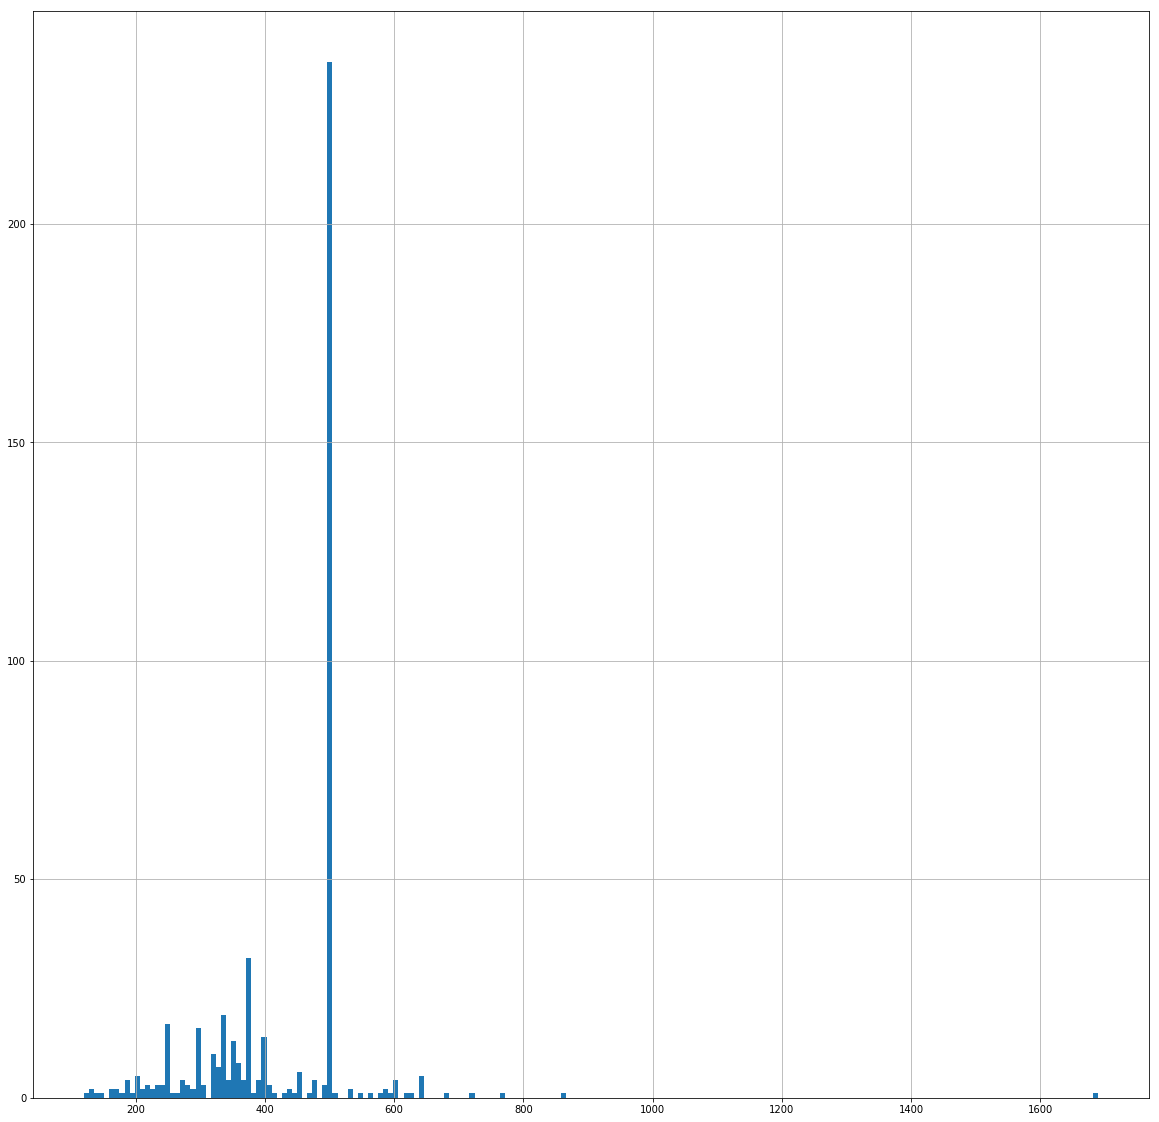

In [6]:
import pandas as pd
df.iloc[0,:].hist(bins=200, figsize=(20,20))

In [7]:
len(np.where(df.iloc[0,:]==500)[0])

236

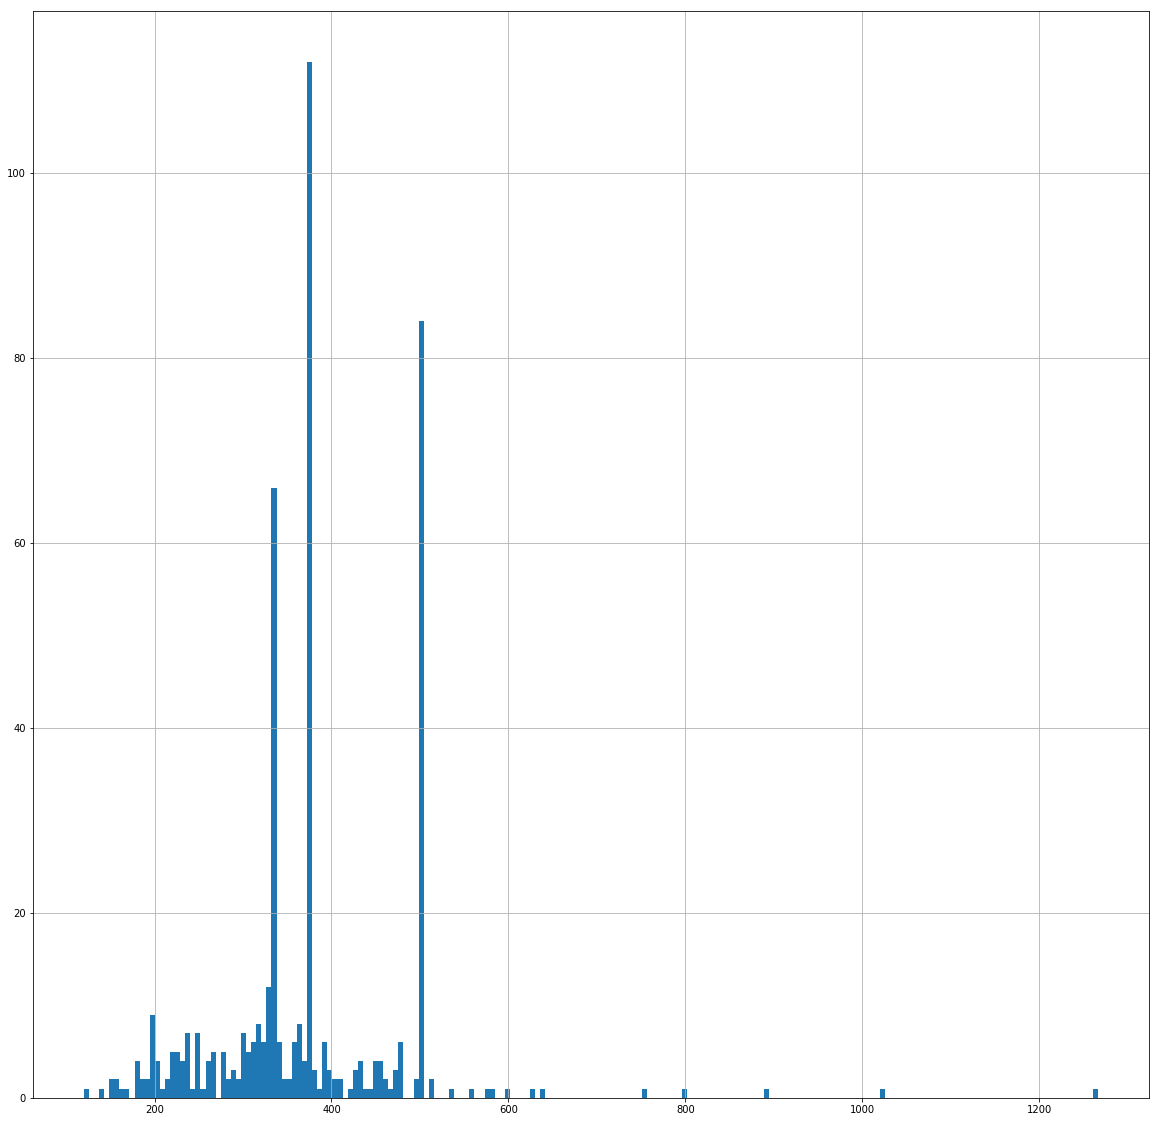

In [8]:
df.iloc[1,:].hist(bins=200, figsize=(20,20))

In [9]:
len(np.where(df.iloc[1,:]==375)[0])

104

# <font color='blus'>1. Images sampling</font>

In [ ]:
image_directory = './data/Images'
breed_count=10
dog_breed_count=4

dict_breed_name = p7_load_breed_name(image_directory)


list_breed_sample = p7_breed_sampling_index(dict_breed_name, breed_count, dog_breed_count)

dict_breed_image, dict_breed_filename,dict_image_pil \
= p7_load_dict_image(image_directory, dict_breed_name, list_breed_sample, dog_breed_count) 

In [648]:
std_size =(500,375)

8


In [649]:
dict_image_pil.keys()

dict_keys(['toy_poodle', 'Lakeland_terrier', 'Cardigan', 'Pekinese', 'Ibizan_hound', 'Dandie_Dinmont', 'affenpinscher', 'Siberian_husky'])

In [653]:
def p7_dict_image_pil_resize(dict_img_pil, resize):
    dict_img_pil_tmp = dict() 
    for breed in dict_img_pil.keys():
        list_img_pil = [img_pil.resize(resize) for img_pil in dict_img_pil[breed]]
        dict_img_pil_tmp[breed] = list_img_pil
    return dict_img_pil

In [654]:
import p7_util
dict_image_pil = p7_dict_image_pil_resize(dict_image_pil,(500,375))

In [656]:
std_size =(500,375)

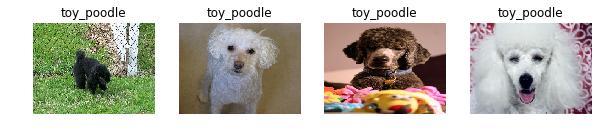

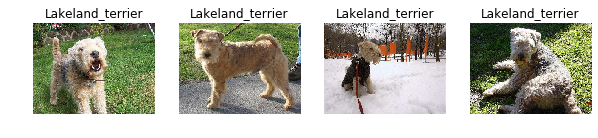

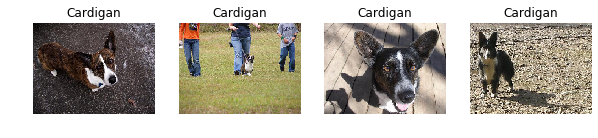

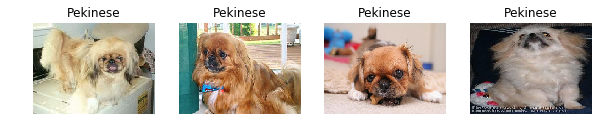

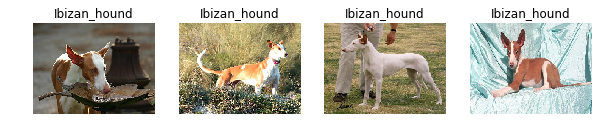

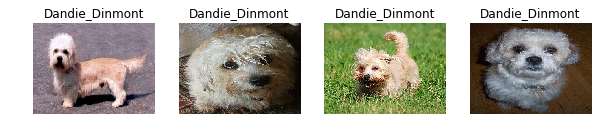

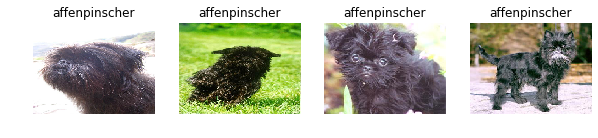

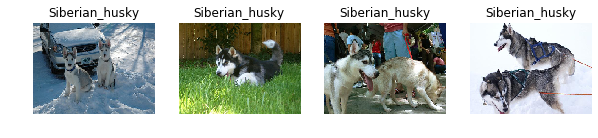

In [657]:
p7_image_pil_show(dict_image_pil,std_image_size=(500,375))

Select a random image from first breed

In [664]:
import numpy as np

breed_pos = random.randint(0, len(dict_image_pil))

8

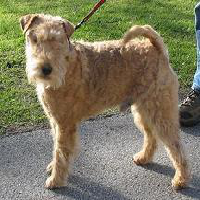

In [667]:
breed = 'Lakeland_terrier'
image_pil = dict_image_pil[breed][1]
image_pil

# <font color='blus'>2. Images whitening</font>

In [12]:
import numpy as np
def zca_whiten(X):
    """
    Applies ZCA whitening to the data (X)
    http://xcorr.net/2011/05/27/whiten-a-matrix-matlab-code/

    X: numpy 2d array
        input data, rows are data points, columns are features

    Returns: ZCA whitened 2d array
    """
    assert(X.ndim == 2)
    EPS = 10e-5

    #   covariance matrix
    cov = np.dot(X.T, X)
    #   d = (lambda1, lambda2, ..., lambdaN)
    u, E, v = np.linalg.eigh(cov)
    #   D = diag(d) ^ (-1/2)
    D = np.diag(1. / np.sqrt(E + EPS))
    #   W_zca = E * D * E.T
    W = np.dot(np.dot(E, D), u.T)

    X_white = np.dot(X, W)

    return X_white

def zca_whitening_matrix(X, rowvar=False):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [M x N] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=rowvar) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,E,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # E: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    D = np.diag(1.0/np.sqrt(E + epsilon))
    ZCAMatrix = np.dot(U, np.dot(D, V)) # [M x M]
    return ZCAMatrix


def flatten_matrix(matrix):
    vector = matrix.flatten(1)
    vector = vector.reshape(1, len(vector))
    return vector

def zca_whitening(inputs):
    sigma = np.dot(inputs, inputs.T)/inputs.shape[1] #Correlation matrix
    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition
    epsilon = 1.e-5                #Whitening constant, it prevents division by zero
    D=np.diag(1.0/np.sqrt(np.diag(S + epsilon)))
    ZCAMatrix = np.dot(np.dot(U,D ),V) #ZCA Whitening matrix
    return np.dot(ZCAMatrix, inputs)   #Data whitening

In [633]:
image_orig = dict_image_pil['Lakeland_terrier'][2]
#image_orig = dict_image_pil['Lakeland_terrier'][1]
arr_image_orig=np.array(image_orig)
print(arr_image_orig.shape)
plt.imshow(arr_image_orig)


KeyError: 'Lakeland_terrier'

(200, 200)


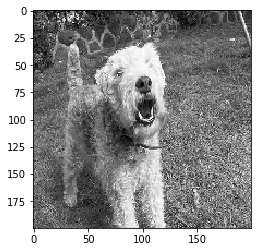

In [629]:
import numpy as np

image_gray = image_orig.convert('L')

arr_image_gray = np.array(image_gray)
arr_image_gray = np.clip(arr_image_grey,0,255)
print(arr_image_gray.shape)

z_=plt.imshow(image_gray)
#p7_util.image_hist(image_grey)

**Equalization**

# <font color='blus'>3. Images Gray</font>

In [ ]:
for breed, list_image_pil in dict_image_pil.items():
    dict_image_pil[breed] = [ image_pil.convert('L') for image_pil in list_image_pil]

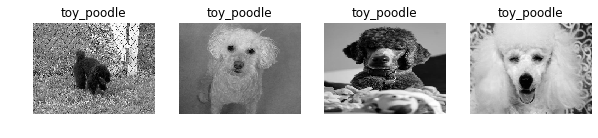

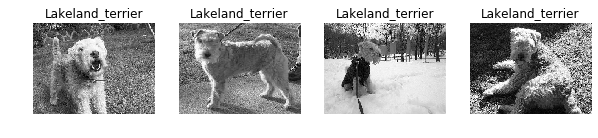

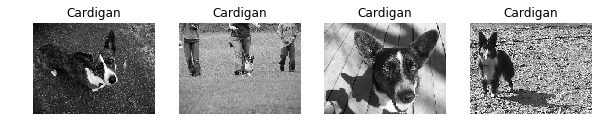

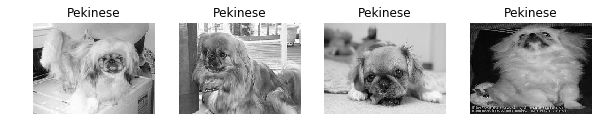

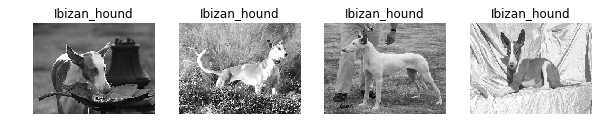

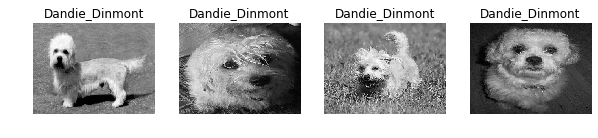

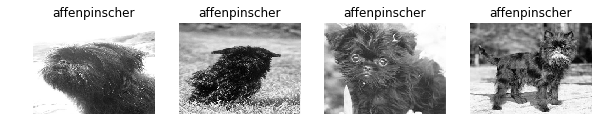

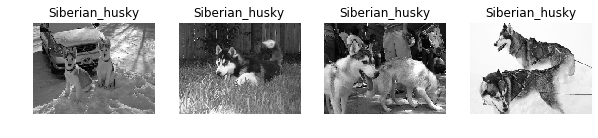

In [674]:
import p7_util
p7_util.p7_image_pil_show(dict_image_pil,std_image_size=(500,375))

# <font color='blus'>3. Images Equalization</font>

In [668]:
dict_image_pil.keys()

dict_keys(['toy_poodle', 'Lakeland_terrier', 'Cardigan', 'Pekinese', 'Ibizan_hound', 'Dandie_Dinmont', 'affenpinscher', 'Siberian_husky'])

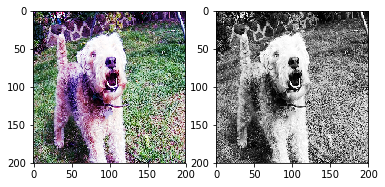

In [494]:
import matplotlib.pyplot as plt
from PIL import ImageOps

image_orig_equalized = ImageOps.equalize(image_orig)
image_gray_equalized = ImageOps.equalize(image_gray)
plt.subplot(1,2,1)
plt.imshow(image_orig_equalized)
plt.subplot(1,2,2)
plt.imshow(image_gray_equalized)


**Filtering : Gaussian , Laplacian, Sobel, Prewitt, Gaussian mask, Median**

dict_keys(['gray', 'equalized', 'median'])


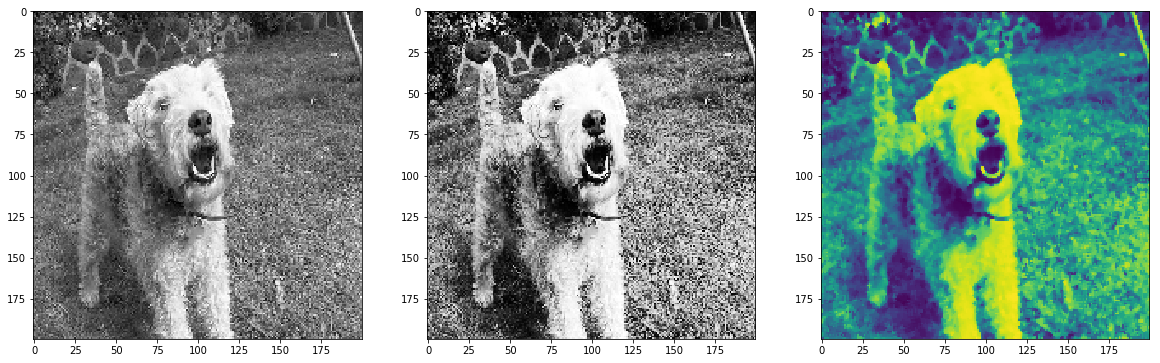

In [630]:
from PIL import Image

from skimage import filters

is_gaussian1 = False
is_median    = True
is_prewitt   = False
is_gaussian2 = False
is_unmasked  = False
is_laplace   = False
is_sobel     = False

dict_image = dict()
#-------------------------------------------------------
# Original image
#-------------------------------------------------------
image_filtered = image_gray_equalized
dict_image['gray'] = image_gray
dict_image['equalized'] = image_filtered

#-------------------------------------------------------
# Median filter : to remove points 
#-------------------------------------------------------
if is_median :
    image_filtered = filters.median(np.array(image_gray_equalized))
    dict_image['median'] = image_filtered

    
#-------------------------------------------------------
# Gaussian filter: Sigma <1. : used in order to reduce noise
#-------------------------------------------------------
if is_gaussian1 :
    image_filtered = filters.gaussian(np.array(image_filtered), sigma=1.e-15,multichannel=False)
    dict_image['gaussian1'] = image_filtered

#-------------------------------------------------------
# Gaussian filter: Sigma >1. : used in order to create a mask
#-------------------------------------------------------
if is_gaussian2 :
    image_filtered = filters.gaussian(np.array(image_filtered), sigma=1.5,multichannel=True)
    dict_image['gaussian2'] = image_filtered

    
#-------------------------------------------------------
# Prewitt filter: to detect shapes
#-------------------------------------------------------
if is_prewitt :
    image_filtered = filters.prewitt(np.array(image_filtered))
    dict_image['prewitt'] = image_filtered

    
#-------------------------------------------------------
# Mask substraction: used in order to filter low frequencies and to display more details 
# from original image
#-------------------------------------------------------
if is_unmasked :
    image_filtered = dict_image['equalized']-dict_image['gaussian2']
    dict_image['unmasked'] = image_filtered

    
#-------------------------------------------------------
# Laplacian filter : draw shape
#-------------------------------------------------------
if is_laplace :
    image_filtered = filters.laplace(image_filtered)
    dict_image['laplace'] = image_filtered
#-------------------------------------------------------
# Sobel filter : draw shape
#-------------------------------------------------------
if is_sobel :
    image_filtered = filters.sobel(image_filtered)
    dict_image['sobel'] = image_filtered


#image_filtered = np.clip(image_filtered,0,255)
#dict_image['gray'] = image_filtered
print(dict_image.keys())
#-------------------------------------------------------
# Display filtered images step by step
#-------------------------------------------------------
if True:
    p7_imshow_raw(dict_image, figsize=(20,10))
    plt.figure(figsize=figsize)
    rank = len(dict_image)
    raw=1
    for pos, filter_name in zip(range(0,rank), dict_image.keys()):
        image_filtered = dict_image[filter_name]
        #image_filtered = np.clip(image_filtered,0,255)
        #image_filtered = image_filtered.astype(int)
        plt.subplot(raw,rank,pos+1)
        #image_pil = Image.fromarray(image_filtered)
        ax = plt.imshow(image_filtered)
        



In [614]:
np.asarray(image_pil)
np.max(image_filtered.flatten()), np.min(image_filtered.flatten())
image_filtered

array([[0.00784314, 0.00392157, 0.01176471, ..., 0.04705882, 0.03137255,
        0.04705882],
       [0.        , 0.02745098, 0.00784314, ..., 0.01960784, 0.03137255,
        0.03921569],
       [0.18431373, 0.08235294, 0.        , ..., 0.03921569, 0.0627451 ,
        0.05490196],
       ...,
       [0.70588235, 0.60392157, 0.41176471, ..., 0.50196078, 0.52941176,
        0.7372549 ],
       [0.14509804, 0.52156863, 0.42352941, ..., 0.20392157, 0.56078431,
        0.4745098 ],
       [0.2627451 , 0.22352941, 0.22352941, ..., 0.40392157, 0.04705882,
        0.87843137]])

dict_keys(['equalized', 'median'])


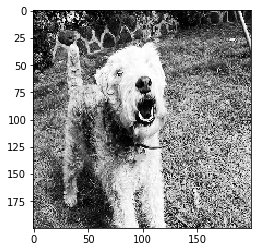

In [625]:
from PIL import Image

print(dict_image.keys())

plt.imshow(dict_image['equalized'])
type(dict_image['equalized'])

image = np.clip(dict_image['median'],0,255)
im = Image.fromarray(image)
#im

((370, 128), dict_keys(['gray', 'equalized', 'median']))

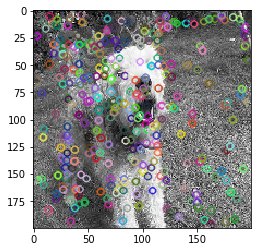

In [694]:
import p7_util
image = np.array(dict_image['gray'])
kp, desc  = p7_util.p7_gen_sift_features(np.array(image))
p7_util.p7_show_sift_features(image, image, kp)
desc.shape,dict_image.keys()

(446, 128)

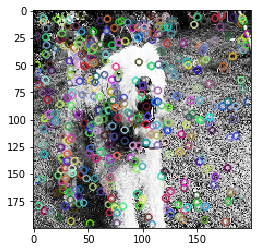

In [676]:
import p7_util
image = np.array(dict_image['equalized'])
kp, desc  = p7_util.p7_gen_sift_features(np.array(image))
p7_util.p7_show_sift_features(image, image, kp)
desc.shape

(855, 128)

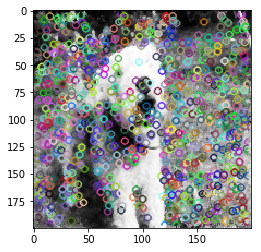

In [632]:
import p7_util
image = np.array(dict_image['median'])
kp, desc  = p7_util.p7_gen_sift_features(np.array(image))
p7_util.p7_show_sift_features(image, image, kp)
desc.shape

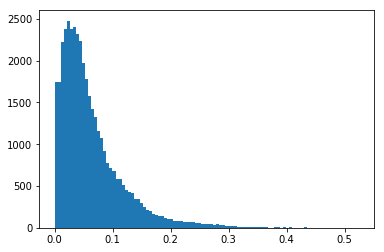

In [508]:
import numpy as np

#plt.hist(dict_image['prewitt'],bins=100);
flatten_image = dict_image['prewitt'].flatten()
plt.hist(flatten_image,bins=100);

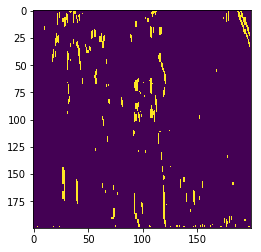

In [509]:
for j in range(0,len(flatten_image)):
    if(flatten_image[j]<0.2) :
        flatten_image[j]=0
    else :
        flatten_image[j]=255
flatten_image_reshape = flatten_image.reshape(200,200)
plt.imshow(flatten_image_reshape)


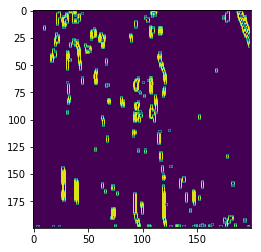

In [523]:
image_filtered = filters.prewitt(np.array(flatten_image_reshape))
dict_image['prewitt2'] = image_filtered
plt.imshow(image_filtered)



In [535]:
image_filtered = image_filtered.astype(np.uint)
type(dict_image['equalized'])

PIL.Image.Image

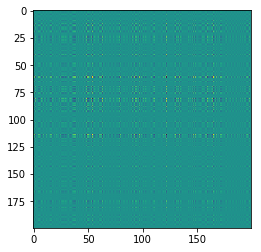

In [352]:
zca_matrix = zca_whitening_matrix(dict_image['original'])

decoralated = np.dot( zca_matrix, image_filtered)
#decoralated = np.clip(decoralated,0,255)
plt.imshow(decoralated)


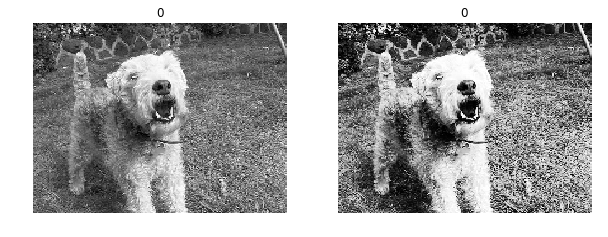

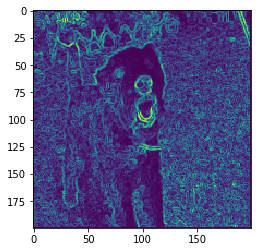

In [257]:
from skimage import filters
import p7_util
arr_image_grey_equalized = np.array(image_grey_equalized)

image_grey_equalized_sobel = filters.sobel(image_grey_equalized)
image_grey_equalized_laplace  = filters.laplace(image_grey_equalized)
image_grey_sobel = filters.sobel(image_grey)
image_grey_laplace = filters.laplace(image_grey)
image_grey_prewitt = filters.prewitt(image_grey)

image_grey_filtered = filters.sobel(image_grey)

dict_image_pil=dict()
dict_image_pil[0] = [image_grey,image_grey_equalized]

p7_image_pil_show(dict_image_pil,std_image_size=(500,375))
plt.imshow(image_grey_equalized_sobel)

numpy.ndarray

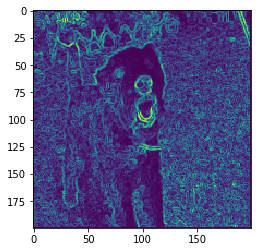

In [245]:
plt.imshow(image_grey_equalized_sobel)
type(image_grey_equalized_sobel)

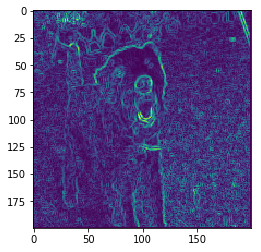

In [251]:
plt.imshow(image_grey_prewitt)

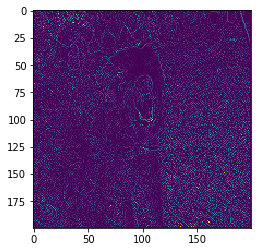

In [211]:
plt.imshow(np.clip(image_grey_laplace,0,255))

In [168]:
tab_0 = np.array(image_orig)[:,:,0]
tab_1 = np.array(image_orig)[:,:,1]
tab_2 = np.array(image_orig)[:,:,2]
tab_0.shape

(200, 200)

In [172]:
from skimage import filters
import p7_util

image_orig_sobel_0 = filters.sobel(tab_0)
image_orig_sobel_1 = filters.sobel(tab_1)
image_orig_sobel_2 = filters.sobel(tab_2)

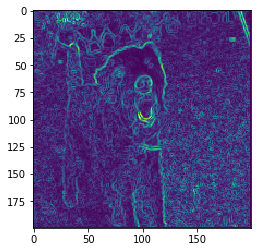

In [177]:
plt.imshow(image_orig_sobel_0+image_orig_sobel_1+image_orig_sobel_2)

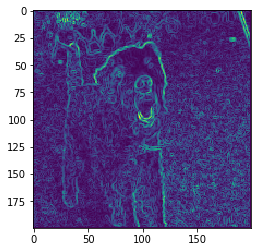

In [175]:
plt.imshow(image_orig_sobel_1)

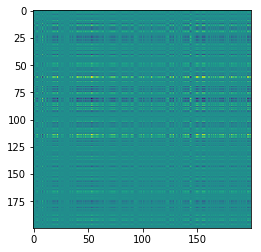

In [87]:
zca_matrix = zca_whitening_matrix(image_grey_equalized)

decoralated = np.dot( zca_matrix, image_grey_equalized)
#decoralated = np.clip(decoralated,0,255)
plt.imshow(decoralated)


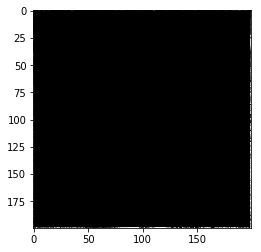

In [98]:
import p7_util
from PIL import Image
from PIL import ImageFilter

lap_kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=np.uint8)

size=(3,3)
lap_filter = ImageFilter.Kernel(size, lap_kernel.flatten(), scale=None, offset=0)

image_filtered = image_grey_equalized.filter(lap_filter)
plt.imshow(image_filtered)
#image_filtered = image_grey_equalized.filter(ImageFilter.MedianFilter(3))
#plt.imshow(image_filtered)


In [91]:
type(lap_filter)

PIL.ImageFilter.Kernel

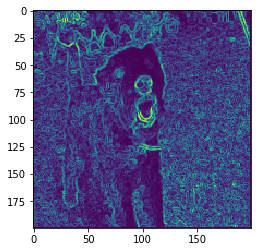

In [141]:
import p7_util
from skimage import filters
image_grey_equalized_filtered = filters.sobel(image_grey_equalized)

plt.imshow(image_grey_equalized_filtered)

In [ ]:
#flatten_matrix = flatten_matrix(arr_image_grey)
vector = arr_image_orig.reshape(-1)#arr_image_grey.flatten(1)
vector = vector.reshape(1,len(vector))
vector.shape
zca = zca_whitening(vector)

zca = np.clip(zca,0,255)
zca_reshape_ = zca.reshape(200,200,3)
print(zca_reshape_.shape)
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(arr_image_orig)
plt.subplot(1,2,2)
plt.imshow(zca_reshape_)


In [ ]:
plt.imshow(zca_reshape_)

In [ ]:
image_grey = image_orig.convert('L')
image_grey

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
#pca = PCA(n_components=200, whiten=True)
pca = PCA(n_components=200, svd_solver='randomized')

In [ ]:
arr_image_orig=np.array(image_grey)
print(arr_image_orig.shape)

#arr_image_orig = arr_image_orig.reshape(-1,arr_image_orig.shape[0]*arr_image_orig.shape[1]*arr_image_orig.shape[2] )
#arr_image_orig.shape


In [ ]:
pca.fit(arr_image_orig)

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(0., 0.95)
plt.grid()

In [ ]:
components=100
pca = PCA(n_components=components, whiten=True)
imgage_whiten = pca.fit_transform(arr_image_orig)
imgage_whiten.shape

In [ ]:
img_inv = np.clip(pca.inverse_transform(imgage_whiten),0,255)
img_inv.shape


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_inv)

In [ ]:
DD = np.dot(arr_image_orig - pca.mean_, pca.components_.T)
DD.shape

In [ ]:
reconstructed_cat.shape

In [ ]:
import pickle
import numpy as np

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def vtoimg(v):
     return np.array(np.clip(v, 0, 255), dtype=np.uint8).reshape(3,32,32).transpose([1,2,0])
def reconstruct(pca, vec):
    return pca.mean_ + np.dot(vec, pca.components_)

In [ ]:
import numpy as np
import pickle
path='./data/cifar-10-batches-py'
dd = np.vstack(tuple(unpickle(path+"/data_batch_{}".format(n))[b'data'] for n in range(1,6)))

#dd = np.vstack((batch1,batch2))
dd.shape
#red_cat_bag = dd[3000].reshape(3,32,32).transpose([1,2,0])
#plt.imshow(red_cat_bag)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=400, random_state=0, svd_solver='randomized')
pca.fit(dd)

In [ ]:
def reconstruct(pca, vec):
    return pca.mean_ + np.dot(vec, pca.components_)

def vtoimg(v):
     return np.array(np.clip(v, 0, 255), dtype=np.uint8).reshape(1,200,200).transpose([1,2,0])
    
reconstructed_cat = vtoimg(reconstruct(pca, DD))

plt.subplot(1,2,1)
plt.imshow(arr_image_orig)
plt.subplot(1,2,2)
plt.imshow(reconstructed_cat)

In [ ]:
tuple(unpickle(path+"/data_batch_{}".format(n))[b'data'] for n in range(1,2))

In [ ]:
print(dd[3000].shape)
print(dd[3000].reshape(3,32,32).shape)

red_cat_bag = dd[3000].reshape(3,32,32).transpose([1,2,0])
print(red_cat_bag.shape)
print(32*32*3)
plt.imshow(red_cat_bag)


In [ ]:
red_cat_bag.shape

In [ ]:
reconstructed_cat = vtoimg(reconstruct(pca, DD[3000]))
plt.subplot(1,2,1)
plt.imshow(red_cat_bag)
plt.subplot(1,2,2)
plt.imshow(reconstructed_cat)

In [ ]:
zca_matrix = zca_whitening_matrix(red_cat_bag)

decoralated = np.dot( zca_matrix, red_cat_bag)
#decoralated = np.clip(decoralated,0,255)
plt.imshow(decoralated)
zca_matrix